<a href="https://colab.research.google.com/github/Deniandel/GradientBoosting/blob/main/GradientBoosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install if needed
!pip install kagglehub
!pip install xgboost

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("yasserh/wine-quality-dataset")
print("Path to dataset files:", path)


Path to dataset files: /kaggle/input/wine-quality-dataset


In [ ]:
df = pd.read_csv(path + "/WineQT.csv")

# Preview
print("Shape:", df.shape)
df.head()


Shape: (1143, 13)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


In [ ]:
df.drop(columns=['Id'], inplace=True)


In [ ]:
X = df.drop('quality', axis=1)
y = df['quality']


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

dt = DecisionTreeRegressor(max_depth=5, random_state=42)
dt.fit(X_train_scaled, y_train)
dt_preds = dt.predict(X_test_scaled)

dt_mse = mean_squared_error(y_test, dt_preds)
dt_rmse = np.sqrt(dt_mse)

print("Decision Tree RMSE:", round(dt_rmse, 4))

Decision Tree RMSE: 0.7103


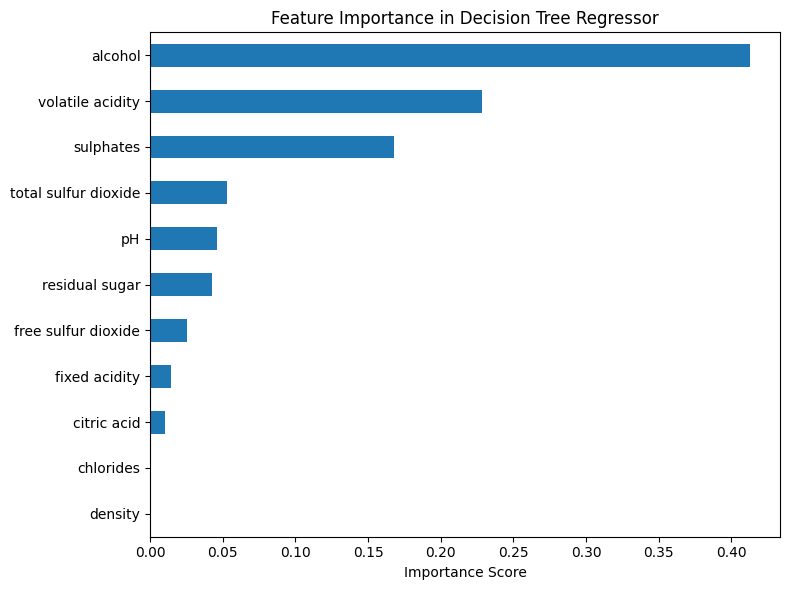

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances from the decision tree
dt_importance = pd.Series(dt.feature_importances_, index=X.columns)

# Plot it
plt.figure(figsize=(8, 6))
dt_importance.sort_values().plot(kind='barh')
plt.title("Feature Importance in Decision Tree Regressor")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


In [ ]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.01,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb.fit(X_train_scaled, y_train)
xgb_preds = xgb.predict(X_test_scaled)

xgb_mse = mean_squared_error(y_test, xgb_preds)
xgb_rmse = np.sqrt(xgb_mse)

print("XGBoost RMSE:", round(xgb_rmse, 4))

XGBoost RMSE: 0.5848


In [ ]:
from sklearn.metrics import r2_score

dt_r2 = r2_score(y_test, dt_preds)
xgb_r2 = r2_score(y_test, xgb_preds)

print("Decision Tree R²:", round(dt_r2, 4))
print("XGBoost R²:", round(xgb_r2, 4))


Decision Tree R²: 0.1324
XGBoost R²: 0.4118


In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [5, 6],
    'subsample': [0.7, .8],
    'colsample_bytree': [0.7, .8]
}

# Set up the model and grid search
xgb_base = XGBRegressor(random_state=42)
grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Run the grid search
grid_search.fit(X_train_scaled, y_train)

# Print best parameters and cross-validated RMSE
print("Best Parameters:", grid_search.best_params_)
print("Best CV RMSE:", round(-grid_search.best_score_, 4))  # negated

# Evaluate on test set
best_xgb = grid_search.best_estimator_
best_preds = best_xgb.predict(X_test_scaled)

best_rmse = np.sqrt(mean_squared_error(y_test, best_preds))
best_r2 = r2_score(y_test, best_preds)

print("Tuned XGBoost RMSE (test set):", round(best_rmse, 4))
print("Tuned XGBoost R² (test set):", round(best_r2, 4))


Fitting 3 folds for each of 96 candidates, totalling 288 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 400, 'subsample': 0.8}
Best CV RMSE: 0.6345
Tuned XGBoost RMSE (test set): 0.5782
Tuned XGBoost R² (test set): 0.4251


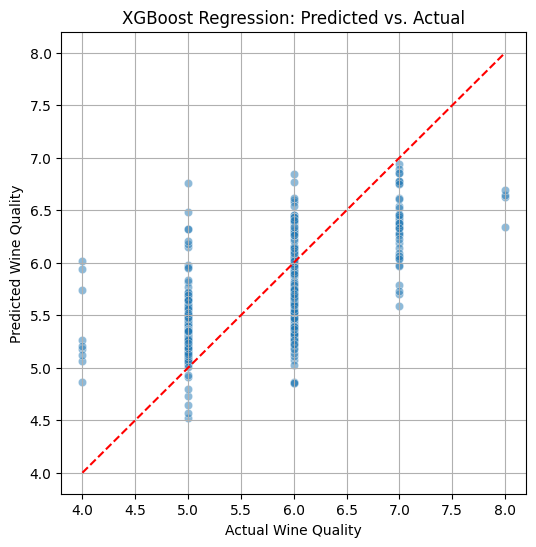

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=xgb_preds, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # 45-degree reference line
plt.xlabel('Actual Wine Quality')
plt.ylabel('Predicted Wine Quality')
plt.title('XGBoost Regression: Predicted vs. Actual')
plt.grid(True)
plt.show()


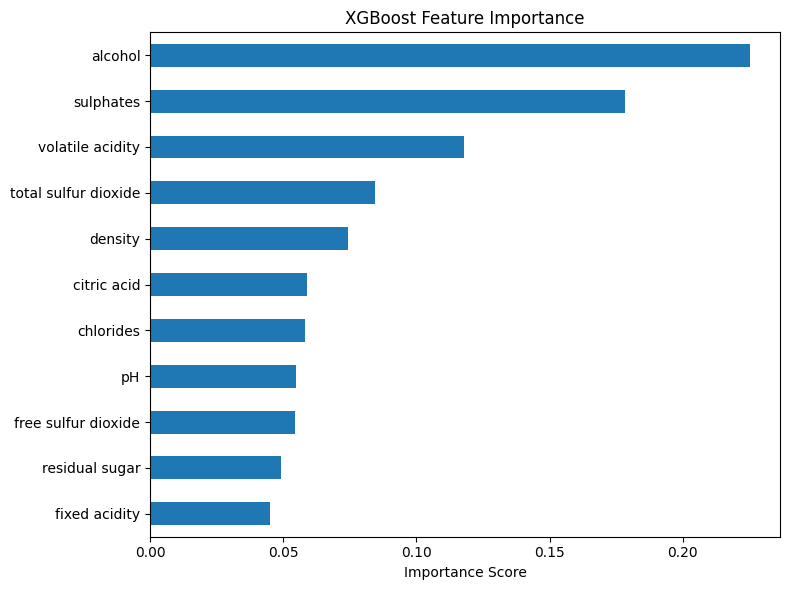

In [ ]:
import pandas as pd
import seaborn as sns

# Feature importances
xgb_importance = pd.Series(xgb.feature_importances_, index=X.columns)
xgb_importance.sort_values().plot(kind='barh', figsize=(8, 6), title="XGBoost Feature Importance")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.preprocessing import LabelEncoder

X_cls = df.drop(columns=['quality'])   # Use your existing DataFrame
y_cls = df['quality']

# Encode labels (3–8) -> (0–5)
le = LabelEncoder()
y_cls_encoded = le.fit_transform(y_cls)


# 3. Train-test split & scale
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X_cls, y_cls_encoded, test_size=0.2, stratify=y_cls_encoded, random_state=42
)

scaler_cls = StandardScaler()
X_train_cls_scaled = scaler_cls.fit_transform(X_train_cls)
X_test_cls_scaled = scaler_cls.transform(X_test_cls)

# 4. Train and evaluate models
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

# ---- Decision Tree Classifier ----
dt_clf = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_clf.fit(X_train_cls_scaled, y_train_cls)
dt_preds = dt_clf.predict(X_test_cls_scaled)

print("Decision Tree Accuracy:", round(accuracy_score(y_test_cls, dt_preds), 4))
print("\nDecision Tree Classification Report:\n", classification_report(y_test_cls, dt_preds))

# ---- XGBoost Classifier ----
xgb_clf = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)
xgb_clf.fit(X_train_cls_scaled, y_train_cls)
xgb_preds = xgb_clf.predict(X_test_cls_scaled)

print("XGBoost Accuracy:", round(accuracy_score(y_test_cls, xgb_preds), 4))
print("\nXGBoost Classification Report:\n", classification_report(y_test_cls, xgb_preds))


Decision Tree Accuracy: 0.5983

Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         7
           2       0.65      0.80      0.72        97
           3       0.59      0.52      0.55        92
           4       0.41      0.38      0.39        29
           5       0.00      0.00      0.00         3

    accuracy                           0.60       229
   macro avg       0.27      0.28      0.28       229
weighted avg       0.56      0.60      0.58       229



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/xgboost/c

XGBoost Accuracy: 0.6812

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         7
           2       0.72      0.78      0.75        97
           3       0.64      0.71      0.67        92
           4       0.75      0.52      0.61        29
           5       0.00      0.00      0.00         3

    accuracy                           0.68       229
   macro avg       0.35      0.33      0.34       229
weighted avg       0.66      0.68      0.67       229



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

# Parameter grid for tuning
param_grid = {
    'n_estimators': [300, 500, 700, 900],
    'max_depth': [4, 5, 6],
    'learning_rate': [0.01, 0.05],
    'subsample': [.7, 0.8],
    'colsample_bytree': [.7, 0.8]
}

# Base model
xgb_base = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

# Grid search with 3-fold CV
grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Fit
grid_search.fit(X_train_cls_scaled, y_train_cls)

# Best model
best_xgb = grid_search.best_estimator_
xgb_cv_preds = best_xgb.predict(X_test_cls_scaled)

# Evaluation
print("Best Parameters:", grid_search.best_params_)
print("Tuned XGBoost Accuracy:", round(accuracy_score(y_test_cls, xgb_cv_preds), 4))
print("\nTuned XGBoost Classification Report:\n", classification_report(y_test_cls, xgb_cv_preds))


Fitting 3 folds for each of 96 candidates, totalling 288 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:20:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 900, 'subsample': 0.8}
Tuned XGBoost Accuracy: 0.6943

Tuned XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         7
           2       0.72      0.81      0.77        97
           3       0.66      0.71      0.68        92
           4       0.71      0.52      0.60        29
           5       0.00      0.00      0.00         3

    accuracy                           0.69       229
   macro avg       0.35      0.34      0.34       229
weighted avg       0.66      0.69      0.68       229



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


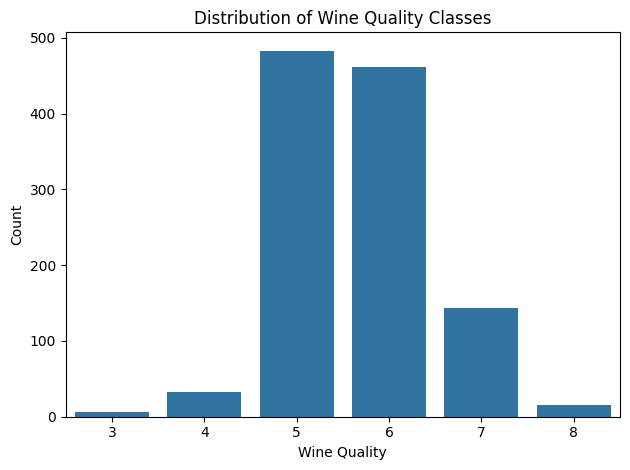

In [ ]:
sns.countplot(x=y_cls)
plt.title("Distribution of Wine Quality Classes")
plt.xlabel("Wine Quality")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


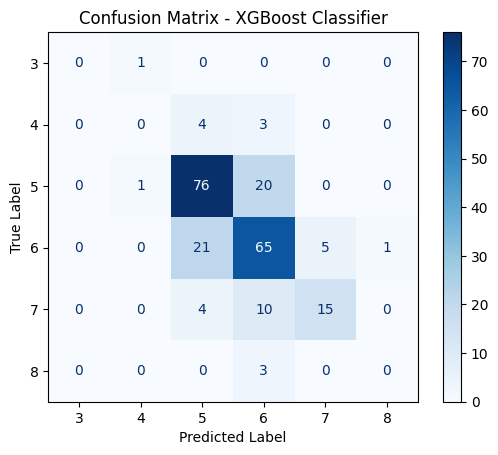

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_cls, xgb_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - XGBoost Classifier")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.grid(False)
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


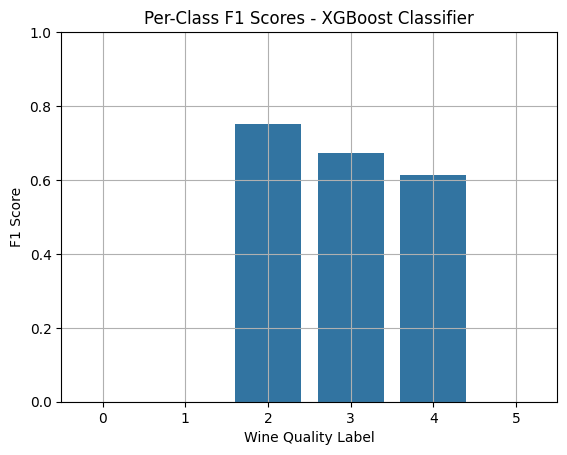

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns

# Get classification report as dictionary
report = classification_report(y_test_cls, xgb_preds, output_dict=True)
f1_scores = {int(k): v['f1-score'] for k, v in report.items() if k.isdigit()}

# Plot
sns.barplot(x=list(f1_scores.keys()), y=list(f1_scores.values()))
plt.title("Per-Class F1 Scores - XGBoost Classifier")
plt.xlabel("Wine Quality Label")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.grid(True)
plt.show()
